In [ ]:
import csv
from collections import defaultdict
from tqdm import tqdm
from random import sample,shuffle
import random
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import pipeline
from sklearn import feature_extraction
from sklearn.tree import DecisionTreeClassifier as DTC
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import norm
from sklearn.model_selection import learning_curve


import pandas

In [2]:
# Read in list of edges from csv
def load_csv(fname="train.txt"):
    with open(fname) as file:
        edges = []
        reader = csv.reader(file, delimiter="\t")
        for row in tqdm(reader, total=20000):
            row = [int(el) for el in row]
            source = row[0]
            sinks = row[1:]
            edges += [(source, sink) for sink in sinks]

        return edges

edges = load_csv()

100%|██████████| 20000/20000 [00:10<00:00, 1826.24it/s]


In [3]:
# Set aside some edges for validation
edges_train, edges_val = model_selection.train_test_split(edges)

In [4]:
# Process a list of edges in to some other useable data
# following is a dictionary of source: # of users source if following
# followers is a dictionary of sink: # of users following sink
# nodes is a dictionary of source: list of sinks
def process(edges):
    following = {}
    followers = {}
    nodes = {}
    nodes_r = {}
    for (source, sink) in tqdm(edges):
        following.setdefault(source, 0)
        following[source] += 1
        followers.setdefault(sink, 0)
        followers[sink] += 1
        nodes.setdefault(source, set())
        nodes[source].add(sink)
        nodes_r.setdefault(sink, set())
        nodes_r[sink].add(source)
    return following, followers, nodes, nodes_r


following, followers, nodes, nodes_r = process(edges)
following_train, followers_train, nodes_train, nodes_r_train = process(edges_train)

100%|██████████| 18003270/18003270 [01:24<00:00, 212998.66it/s]


In [5]:
# Get the correct y value for a data point
def get_y(source, sink):
    return 1 if source in nodes and sink in nodes[source] else 0

In [6]:
def friend_is_following(source, sink):
    for friend in nodes_train.get(source, []):
        if sink in nodes_train.get(friend, []):
            return 1
    return 0

def friends_following(source, sink):
    return sum(1 for friend in nodes_train.get(source, []) if sink in nodes_train.get(friend, []))

def jaccard(a, b):
    a = set(a)
    b = set(b)
    if len(a) == 0 and len(b) == 0:
        return 0.0
    return 100.0 * len(a.intersection(b)) / len(a.union(b))

def cosine(a, b):
    a = set(a)
    b = set(b)
    union = a.union(b)
    union = list(union)
    if len(a) == 0 or len(b) == 0:
        return 0.0
    a = [1 if i in a else 0 for i in union]
    b = [1 if i in b else 0 for i in union]
    cos = dot(a, b) / (norm(a) * norm(b))
#     if np.isnan(cos):
#         print("ahh")
#         print(dot(a, b))
#         print(norm(a))
#         print(norm(b))
#         print(norm(a) * norm(b))
#         1/0
    return cos

In [7]:
# Encode the training "X" data and "y" value of a data point (edge)
def make_row(source, sink):
    n_following = following_train.get(source, 0)
    n_followers = followers_train.get(sink, 0)
    follows_back = 1 if source in nodes_train.get(sink, []) else 0
    n_friends_following = friends_following(source, sink)
#     friend_following = friend_is_following(source, sink)
    cos_f = cosine(nodes_train.get(source, []), nodes_train.get(sink, []))

    
    return {
        "n_following": n_following,
        "n_followers": n_followers,
        "less_followers": 1 if n_following > n_followers else 0,
        "follows_back": follows_back,
        "n_friends_following": n_friends_following,
        "jaccard_following": jaccard(nodes_train.get(source, []), nodes_train.get(sink, [])),
        "jaccard_followers": jaccard(nodes_r_train.get(source, []), nodes_r_train.get(sink, [])),
        "jaccard_forward": jaccard(nodes_train.get(source, []), nodes_r_train.get(sink, [])),
        "jaccard_backward": jaccard(nodes_r_train.get(source, []), nodes_train.get(sink, [])),
        "cosine_following": cos_f,
        "cosine_followers": cosine(nodes_r_train.get(source, []), nodes_r_train.get(sink, [])),
        "cosine_forward": cosine(nodes_train.get(source, []), nodes_r_train.get(sink, [])),
        "cosine_backward": cosine(nodes_r_train.get(source, []), nodes_train.get(sink, [])),
    }

In [8]:
# Given a list of edges, create X and y matrices of features
def prep(edges):
    X = []
    y = []

    for (source, sink) in tqdm(edges):
        X_row = make_row(source, sink)
        X.append(X_row)
        y.append(get_y(source, sink))
    
    return X, y

In [9]:
# Randomly generate new edges, based on a set of existing edges
def random_edges(edges, n):
    return [(random.choice(edges)[0], random.choice(edges)[1]) for i in range(n)]

In [10]:
# Make our final training data, by sampling from existing edges, and adding in other random edges
# We sample a small subset from our training data for computational reasons
edges_train_ = sample(edges_train, k=500) + random_edges(edges_train, 500)
X_train_basic, y_train= prep(edges_train_)

100%|██████████| 1000/1000 [01:25<00:00, 11.71it/s]


In [11]:
edges_val_ = sample(edges_val, k=200) + random_edges(edges_train, 200)
X_val_basic, y_val = prep(edges_val_)

# Frequency count to check how unbalanced our classes are
print(pandas.Series(y_train).value_counts())
print(pandas.Series(y_val).value_counts())

100%|██████████| 400/400 [00:26<00:00, 15.14it/s]

1    548
0    452
dtype: int64
1    212
0    188
dtype: int64


In [12]:
def inv(X):
    return np.hstack([X, 1 / (X + 1), X==0, ])

search_params = range(2, 12, 2)

model = Pipeline([
    ('vec', feature_extraction.DictVectorizer(sparse=False)),
    ('norm', preprocessing.StandardScaler()),
#     ('inv', preprocessing.FunctionTransformer(inv)),
#     ('poly', preprocessing.PolynomialFeatures()),
#     ('feats', feature_selection.SelectKBest(k=4)),
#     ('model', model_selection.GridSearchCV(feature_selection.RFE(LR()), [{"n_features_to_select": search_params}], verbose=2))
    ('feats', feature_selection.RFE(LR(), n_features_to_select=10)),
])

# model.fit(X_train_basic, y_train)

s = model.named_steps
# names = s['vec'].get_feature_names()
# names = names + ["1/(" + name + ")" for name in names] + [name + " == 0" for name in names]
# names = s['poly'].get_feature_names(names)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_features_to_select=2 ..........................................
[CV] ........................... n_features_to_select=2, total=   0.0s
[CV] n_features_to_select=2 ..........................................
[CV] ........................... n_features_to_select=2, total=   0.0s
[CV] n_features_to_select=2 ..........................................
[CV] ........................... n_features_to_select=2, total=   0.0s
[CV] n_features_to_select=4 ..........................................
[CV] ........................... n_features_to_select=4, total=   0.0s
[CV] n_features_to_select=4 ..........................................
[CV] ........................... n_features_to_select=4, total=   0.0s
[CV] n_features_to_select=4 ..........................................
[CV] ........................... n_features_to_select=4, total=   0.0s
[CV] n_features_to_select=6 ..........................................
[CV] ............

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


In [13]:
# names = s['vec'].get_feature_names()
# # names = names + ["1/(" + name + ")" for name in names] + [name + " == 0" for name in names]
# names = s['poly'].get_feature_names(names)
# list(zip(s['feats'].support_, names))

range(2, 12, 2)
[0.61900373 0.63200776 0.62551623 0.62702073 0.6620288 ]
[0.587 0.599 0.622 0.624 0.643]


/usr/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


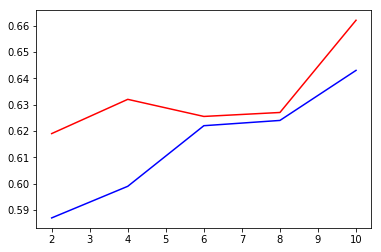

KeyError: 'poly'

In [14]:
print(search_params)

cv_res = s['model'].cv_results_
print(cv_res['mean_train_score'])
print(cv_res['mean_test_score'])

plt.plot(search_params, cv_res['mean_test_score'], 'b', label='test')
plt.plot(search_params, cv_res['mean_train_score'], 'r', label='train')
plt.show()

names = s['vec'].get_feature_names()
# names = names + ["1/(" + name + ")" for name in names] + [name + " == 0" for name in names]
names = s['poly'].get_feature_names(names)
list(zip(s['model'].best_estimator_.support_, names))

In [ ]:
# Check how we score against the validation set
print(model.score(X_val_basic, y_val))
print(metrics.classification_report(model.predict(X_val_basic), y_val))

In [ ]:
# Check how many accurate predictions we have for each class
print(confusion_matrix(model.predict(X_val_basic), y_val))

In [ ]:
# Read in the test data, make predictions with a model, write to a new csv
def make_submission(model, file_in="test-public.txt", file_out="predictions.csv"):
    edges = []
    with open(file_in) as file:
        reader = csv.reader(file, delimiter="\t")
        header = True
        for row in tqdm(reader):
            if header:
                header = False
                continue
            row = [int(el) for el in row]
            id, source, sink = row
            edges.append(tuple([source, sink]))
            
    X_test, _ = prep(edges)
    y_pred = model.predict_proba(X_test)
        
    with open(file_out, 'w') as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerow(["Id", "Prediction"])
        for i in range(len(y_pred)):
            writer.writerow([i+1, y_pred[i][1]])

In [ ]:
make_submission(model)